In [40]:
import numpy as np
from autogluon.tabular import TabularPredictor
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [51]:
#평가결과리스트
all_accuracy = []
all_f1_score = []

In [41]:
from sklearn.tree import DecisionTreeClassifier
num_features = [
    "Contract_period",
    "Age",
    "Avg_additional_charges_total",
    "Month_to_end_contract",
    "Lifetime",
    "Avg_class_frequency_total",
    "Avg_class_frequency_current_month"]

df = pd.read_csv("C:/Users/Playdata/Desktop/project2/gym_churn_us.csv")
df = df.rename(columns={"Churn": "target"})
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

ss = StandardScaler()
X[num_features] = ss.fit_transform(X[num_features])
dtc = DecisionTreeClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(dtc, X, y, cv=cv)
print(classification_report(y,y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9274    0.9302    0.9288      2939
           1     0.8051    0.7983    0.8017      1061

    accuracy                         0.8952      4000
   macro avg     0.8663    0.8643    0.8653      4000
weighted avg     0.8950    0.8952    0.8951      4000



In [52]:
# 파새변수생성 + Smote미적용
from sklearn.tree import DecisionTreeClassifier
num_features = [
    "Contract_period",
    "Age",
    "Avg_additional_charges_total",
    "Month_to_end_contract",
    "Lifetime",
    "Avg_class_frequency_total",
    "Avg_class_frequency_current_month",
    "social_connected",
    "avg_monthly_add_charge",
    "class_freq_ratio"]

df = pd.read_csv("C:/Users/Playdata/Desktop/project2/gym_churn_us.csv")
df = df.rename(columns={"Churn": "target"})
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X['social_connected'] = X['Partner'] + X['Promo_friends'] + X['Group_visits']   # 고객의 사회적 연결이 얼마나 되어있는지 나타내는 피쳐
X['avg_monthly_add_charge'] = X['Avg_additional_charges_total'] / (X['Lifetime'] + 1)   # 평균 추가 요금의 시간 기준 비율
X['class_freq_ratio'] = X['Avg_class_frequency_current_month'] / (X['Avg_class_frequency_total'] + 1e-5)    # 클래스 이용 변화율 (최근 대비 전체)
X['class_freq_change'] = X['Avg_class_frequency_current_month'] - X['Avg_class_frequency_total']    # 이용 행동 변화량
X['contract_ending_soon'] = (X['Month_to_end_contract'] <= 1).astype(int)      # 계약 만료 임박 여부 (1개월 이내)
X['social_connected_ratio'] = (X['Partner'] + X['Promo_friends'] + X['Group_visits']) / 3     # 사회적 연결의 강도 비율

ss = StandardScaler()
X[num_features] = ss.fit_transform(X[num_features])
dtc = DecisionTreeClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(dtc, X, y, cv=cv)
f1 = f1_score(y, y_pred)
accuracy = accuracy_score(y, y_pred)
all_accuracy.append(accuracy)
all_f1_score.append(f1)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y,y_pred, digits=4))

Accuracy: 0.9260
F1 Score: 0.8610
              precision    recall  f1-score   support

           0     0.9509    0.9483    0.9496      2939
           1     0.8578    0.8643    0.8610      1061

    accuracy                         0.9260      4000
   macro avg     0.9043    0.9063    0.9053      4000
weighted avg     0.9262    0.9260    0.9261      4000



In [48]:
# SMOTE 적용
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


y_pred = cross_val_predict(pipeline, X[num_features], y, cv=cv)
f1 = f1_score(y, y_pred)
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y,y_pred, digits=4))

Accuracy: 0.9220
F1 Score: 0.8560
              precision    recall  f1-score   support

           0     0.9537    0.9394    0.9465      2939
           1     0.8389    0.8737    0.8560      1061

    accuracy                         0.9220      4000
   macro avg     0.8963    0.9066    0.9012      4000
weighted avg     0.9233    0.9220    0.9225      4000



In [53]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline

# 이진 분류 모델들
models = {
    'Logistic Regression' : LogisticRegression(random_state=42),
    'Random Forest' : RandomForestClassifier(random_state=42),
    'XGBoost' : XGBClassifier(random_state=42),
    'LightGBM' : LGBMClassifier(random_state=42),
    'CatBoostClassifier' : CatBoostClassifier(logging_level='Silent',random_state=42)
}

# 교차검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 결과 저장
results = {}

for name, model in models.items():
    print(f"\n Model: {name}")
    
    # 파이프라인 구성
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # 교차검증 예측
    y_pred = cross_val_predict(pipeline, X[num_features], y, cv=cv)
    
    # 분류 리포트 출력 및 저장
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    all_accuracy.append(accuracy)
    all_f1_score.append(f1)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y,y_pred, digits=4))


 Model: Logistic Regression
Accuracy: 0.9180
F1 Score: 0.8549
              precision    recall  f1-score   support

           0     0.9661    0.9207    0.9429      2939
           1     0.8057    0.9105    0.8549      1061

    accuracy                         0.9180      4000
   macro avg     0.8859    0.9156    0.8989      4000
weighted avg     0.9235    0.9180    0.9195      4000


 Model: Random Forest
Accuracy: 0.9453
F1 Score: 0.8971
              precision    recall  f1-score   support

           0     0.9638    0.9616    0.9627      2939
           1     0.8942    0.9001    0.8971      1061

    accuracy                         0.9453      4000
   macro avg     0.9290    0.9308    0.9299      4000
weighted avg     0.9454    0.9453    0.9453      4000


 Model: XGBoost
Accuracy: 0.9490
F1 Score: 0.9037
              precision    recall  f1-score   support

           0     0.9647    0.9660    0.9653      2939
           1     0.9054    0.9020    0.9037      1061

    accurac

# automl

In [56]:
# 각 모델 1번씩 피트
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
from autogluon.tabular import TabularPredictor
from sklearn.metrics import classification_report

# 데이터 로딩 및 피처 엔지니어링
df = pd.read_csv("C:/Users/Playdata/Desktop/project2/gym_churn_us.csv")
df = df.rename(columns={"Churn": "target"})
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# 추가 피처 생성
X['social_connected'] = X['Partner'] + X['Promo_friends'] + X['Group_visits']
X['avg_monthly_add_charge'] = X['Avg_additional_charges_total'] / (X['Lifetime'] + 1)
X['class_freq_ratio'] = X['Avg_class_frequency_current_month'] / (X['Avg_class_frequency_total'] + 1e-5)
X['class_freq_change'] = X['Avg_class_frequency_current_month'] - X['Avg_class_frequency_total']
X['contract_ending_soon'] = (X['Month_to_end_contract'] <= 1).astype(int)
X['social_connected_ratio'] = (X['Partner'] + X['Promo_friends'] + X['Group_visits']) / 3

# 최종 데이터 통합
data = X.copy()
data['target'] = y

# 훈련/검증 데이터 분리
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['target'], random_state=42)

# SMOTE 적용
X_train = train_data.drop('target', axis=1)
y_train = train_data['target']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 재조합
train_resampled = X_resampled.copy()
train_resampled['target'] = y_resampled

# AutoGluon 학습
time_limit = 60 * 10  # 10분
eval_metric = 'f1_weighted'

predictor = TabularPredictor(label='target', path='AutogluonModels/', eval_metric=eval_metric)
predictor.fit(train_resampled, time_limit=time_limit)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       18.28 GB / 31.64 GB (57.8%)
Disk Space Avail:   388.70 GB / 475.90 GB (81.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference speed.
	presets='good'         : Good accu

In [57]:
leaderboard = predictor.leaderboard(silent=True)
leaderboard

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost,0.965999,f1_weighted,0.011081,6.438682,0.011081,6.438682,1,True,11
1,WeightedEnsemble_L2,0.965999,f1_weighted,0.018081,7.580248,0.006999,1.141566,2,True,14
2,LightGBMLarge,0.964000,f1_weighted,0.020238,25.652006,0.020238,25.652006,1,True,13
3,LightGBM,0.960000,f1_weighted,0.020548,10.490946,0.020548,10.490946,1,True,4
4,CatBoost,0.958000,f1_weighted,0.000000,5.553396,0.000000,5.553396,1,True,7
5,LightGBMXT,0.958000,f1_weighted,0.007540,6.820744,0.007540,6.820744,1,True,3
6,NeuralNetFastAI,0.958000,f1_weighted,0.041582,24.632879,0.041582,24.632879,1,True,10
7,NeuralNetTorch,0.957996,f1_weighted,0.021357,108.823253,0.021357,108.823253,1,True,12
8,RandomForestGini,0.952000,f1_weighted,0.146233,2.399714,0.146233,2.399714,1,True,5
9,RandomForestEntr,0.951999,f1_weighted,0.170869,2.394289,0.170869,2.394289,1,True,6


In [58]:
# 검증 데이터에서 feature만 따로 분리
X_val = val_data.drop(columns=['target'])
y_val = val_data['target']

# 예측
y_pred = predictor.predict(X_val)

# 결과 확인 (예: 정확도, F1 점수 등)
from sklearn.metrics import f1_score, classification_report

f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
all_accuracy.append(accuracy)
all_f1_score.append(f1)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
# print(classification_report(y,y_pred, digits=4))

# print("F1 Score:", f1_score(y_val, y_pred, average='weighted'))
# print("\nClassification Report:\n", classification_report(y_val, y_pred, digits=4))

Accuracy: 0.9575
F1 Score: 0.9190


ValueError: Found input variables with inconsistent numbers of samples: [4000, 800]

In [59]:
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_val,y_pred, digits=4))

Accuracy: 0.9575
F1 Score: 0.9190
              precision    recall  f1-score   support

           0     0.9679    0.9745    0.9712       588
           1     0.9279    0.9104    0.9190       212

    accuracy                         0.9575       800
   macro avg     0.9479    0.9424    0.9451       800
weighted avg     0.9573    0.9575    0.9574       800



In [61]:
# 같은 모델 5번씩
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
from autogluon.tabular import TabularPredictor
from sklearn.metrics import classification_report

# 데이터 로딩 및 피처 엔지니어링
df = pd.read_csv("C:/Users/Playdata/Desktop/project2/gym_churn_us.csv")
df = df.rename(columns={"Churn": "target"})
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# 추가 피처 생성
X['social_connected'] = X['Partner'] + X['Promo_friends'] + X['Group_visits']
X['avg_monthly_add_charge'] = X['Avg_additional_charges_total'] / (X['Lifetime'] + 1)
X['class_freq_ratio'] = X['Avg_class_frequency_current_month'] / (X['Avg_class_frequency_total'] + 1e-5)
X['class_freq_change'] = X['Avg_class_frequency_current_month'] - X['Avg_class_frequency_total']
X['contract_ending_soon'] = (X['Month_to_end_contract'] <= 1).astype(int)
X['social_connected_ratio'] = (X['Partner'] + X['Promo_friends'] + X['Group_visits']) / 3

# 최종 데이터 통합
data = X.copy()
data['target'] = y

# 훈련/검증 데이터 분리
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['target'], random_state=42)

# AutoGluon 학습
time_limit = 60 * 10  # 10분
eval_metric = 'f1_weighted'

predictor = TabularPredictor(label='target', path='AutogluonModels/', eval_metric=eval_metric)
predictor.fit(train_data, time_limit=time_limit,  num_bag_folds=5, num_bag_sets=1)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       16.38 GB / 31.64 GB (51.8%)
Disk Space Avail:   387.18 GB / 475.90 GB (81.4%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference speed.
	presets='good'         : Good accu

In [62]:
leaderboard = predictor.leaderboard(silent=True)
leaderboard

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.962589,f1_weighted,2.288449,113.953620,0.013304,2.422678,2,True,14
1,NeuralNetTorch_BAG_L1,0.957403,f1_weighted,0.231461,52.160855,0.231461,52.160855,1,True,12
2,LightGBMXT_BAG_L1,0.956736,f1_weighted,0.055574,15.343406,0.055574,15.343406,1,True,3
3,CatBoost_BAG_L1,0.956607,f1_weighted,0.027486,11.706323,0.027486,11.706323,1,True,7
4,NeuralNetFastAI_BAG_L1,0.956266,f1_weighted,0.260242,27.376209,0.260242,27.376209,1,True,10
5,XGBoost_BAG_L1,0.955780,f1_weighted,0.057460,7.814122,0.057460,7.814122,1,True,11
6,LightGBM_BAG_L1,0.954916,f1_weighted,0.036128,12.845212,0.036128,12.845212,1,True,4
7,LightGBMLarge_BAG_L1,0.953101,f1_weighted,0.065742,27.494266,0.065742,27.494266,1,True,13
8,RandomForestGini_BAG_L1,0.951338,f1_weighted,0.543134,2.493307,0.543134,2.493307,1,True,5
9,RandomForestEntr_BAG_L1,0.951276,f1_weighted,0.538885,2.382858,0.538885,2.382858,1,True,6


In [63]:
# 검증 데이터에서 feature만 따로 분리
X_val = val_data.drop(columns=['target'])
y_val = val_data['target']

# 예측
y_pred = predictor.predict(X_val)

# 결과 확인 (예: 정확도, F1 점수 등)
from sklearn.metrics import f1_score, classification_report

f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
all_accuracy.append(accuracy)
all_f1_score.append(f1)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_val,y_pred, digits=4))

C:\Users\Playdata\miniconda3\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
C:\Users\Playdata\miniconda3\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only lo

Accuracy: 0.9637
F1 Score: 0.9301
              precision    recall  f1-score   support

           0     0.9682    0.9830    0.9755       588
           1     0.9507    0.9104    0.9301       212

    accuracy                         0.9637       800
   macro avg     0.9595    0.9467    0.9528       800
weighted avg     0.9636    0.9637    0.9635       800



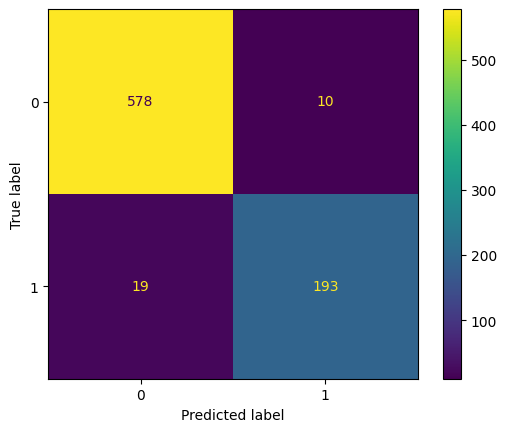

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# 정오분류표 계산
cm = confusion_matrix(y_val, y_pred)

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

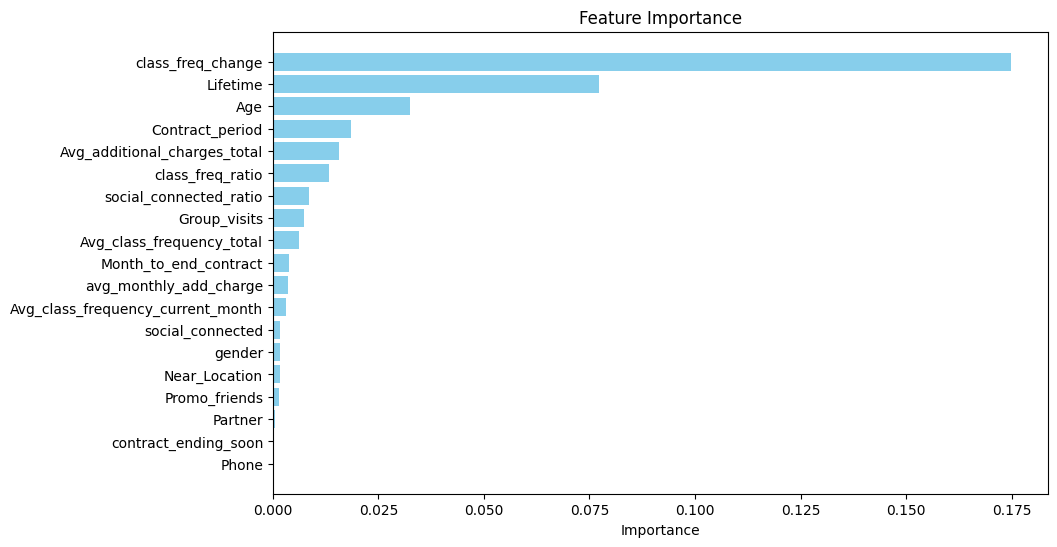

In [108]:
# feature_importance의 중요도 컬럼과 피쳐 이름을 합치기
importance_df = feature_importance[['importance']].copy()

# feature_importance에 포함된 피쳐 이름 확인
important_features = importance_df.index  # index는 피쳐 이름을 나타냄

# train_data의 피쳐 이름이 feature_importance와 맞는지 확인
train_features = train_data.columns

# 일치하는 피쳐 이름만 사용
matching_features = [feature for feature in train_features if feature in important_features]

# 중요도를 내림차순으로 정렬
importance_df = importance_df.loc[matching_features]
importance_df = importance_df.sort_values(by='importance', ascending=True)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df.index, importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [66]:
import joblib

# 모델 저장
joblib.dump(model, 'model.pkl')

# 모델 불러오기
loaded_model = joblib.load('model.pkl')

In [89]:
models = ['DecisionTreeClassifier','Logistic Regression','Random Forest','XGBoost','LightGBM','CatBoostClassifier,','autoML']

In [93]:
print(all_accuracy)
print(all_f1_score)

[0.926, 0.918, 0.94525, 0.949, 0.94975, 0.9515, 0.9575, 0.96375, 0.96375]
[0.8610328638497653, 0.8548672566371681, 0.8971348050728042, 0.9036827195467422, 0.9052333804809052, 0.9093457943925234, 0.919047619047619, 0.9301204819277108, 0.9301204819277108]


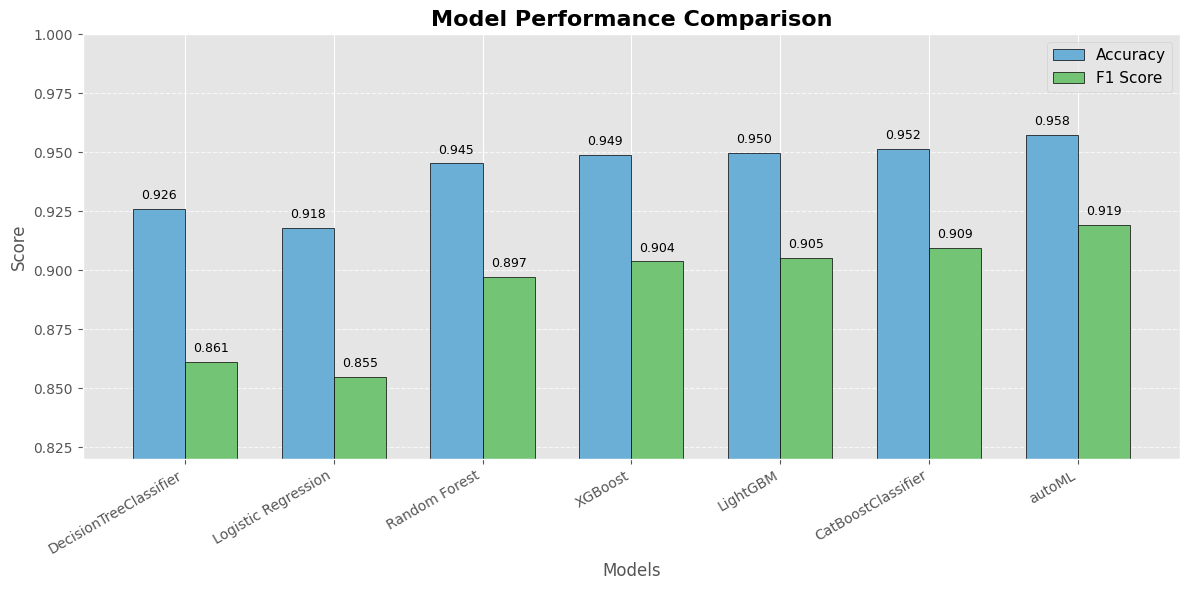

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# 스타일 적용
plt.style.use('ggplot')  # 깔끔한 스타일

# 모델 이름
models = ['DecisionTreeClassifier', 'Logistic Regression', 'Random Forest',
          'XGBoost', 'LightGBM', 'CatBoostClassifier', 'autoML']

# 정확도와 F1-score
accuracy = [0.926, 0.918, 0.94525, 0.949, 0.94975, 0.9515, 0.9575]
f1_scores = [0.8610328638497653, 0.8548672566371681, 0.8971348050728042,
             0.9036827195467422, 0.9052333804809052, 0.9093457943925234, 0.919047619047619]

# 위치 설정
x = np.arange(len(models))
width = 0.35

# 그래프 생성
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy',
               color='#6baed6', edgecolor='black')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score',
               color='#74c476', edgecolor='black')

# y축 범위 설정
ax.set_ylim(0.82, 1.0)

# 라벨 설정
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha='right', fontsize=10)
ax.legend(fontsize=11)

# 그리드 추가
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# 막대 위에 값 표시
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.annotate(f'{yval:.3f}', xy=(bar.get_x() + bar.get_width() / 2, yval),
                xytext=(0, 5), textcoords="offset points",
                ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

### 전체데이터

In [5]:
result_df = data.copy()
preds = predictor.predict(data)
result_df['predict'] = preds
preds_proba = predictor.predict_proba(data)
result_df['predict_proba'] = preds_proba.iloc[:,1]

labels = []
for proba in result_df['predict_proba']:
  if proba >= 0.9:
    labels += [2]
  elif 0.5 <= proba <0.9:
    labels += [1]
  else:
    labels += [0]

result_df['predict_proba'] = labels

C:\Users\Playdata\miniconda3\envs\env1\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
C:\Users\Playdata\miniconda3\envs\env1\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code w

C:\Users\Playdata\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:16:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Playdata\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:16:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Playdata\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:16:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Playdata\miniconda3\Li

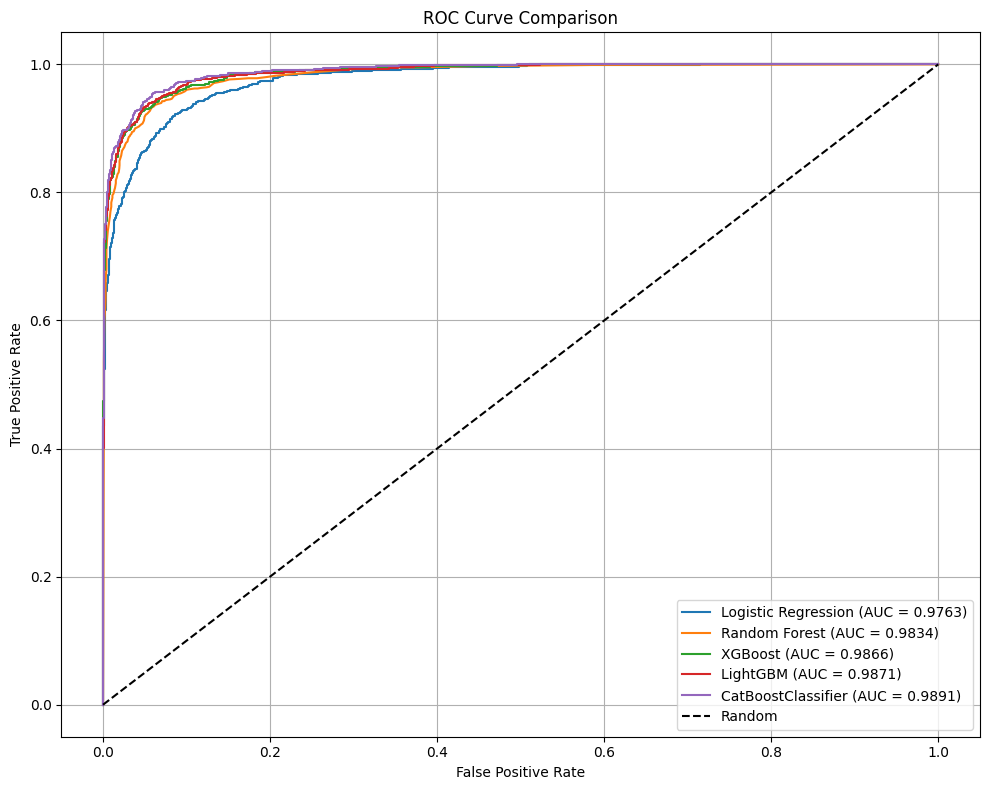

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import pandas as pd

# 데이터 로드 및 전처리 (이미 한 것들은 생략 가능)
df = pd.read_csv("C:/Users/Playdata/Desktop/project2/gym_churn_us.csv")
df = df.rename(columns={"Churn": "target"})
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X['social_connected'] = X['Partner'] + X['Promo_friends'] + X['Group_visits']
X['avg_monthly_add_charge'] = X['Avg_additional_charges_total'] / (X['Lifetime'] + 1)
X['class_freq_ratio'] = X['Avg_class_frequency_current_month'] / (X['Avg_class_frequency_total'] + 1e-5)
X['class_freq_change'] = X['Avg_class_frequency_current_month'] - X['Avg_class_frequency_total']
X['contract_ending_soon'] = (X['Month_to_end_contract'] <= 1).astype(int)
X['social_connected_ratio'] = (X['Partner'] + X['Promo_friends'] + X['Group_visits']) / 3

num_features = [
    "Contract_period",
    "Age",
    "Avg_additional_charges_total",
    "Month_to_end_contract",
    "Lifetime",
    "Avg_class_frequency_total",
    "Avg_class_frequency_current_month",
    "social_connected",
    "avg_monthly_add_charge",
    "class_freq_ratio"
]

# 모델 정의
models = {
    'Logistic Regression' : LogisticRegression(random_state=42),
    'Random Forest' : RandomForestClassifier(random_state=42),
    'XGBoost' : XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM' : LGBMClassifier(random_state=42),
    'CatBoostClassifier' : CatBoostClassifier(logging_level='Silent', random_state=42)
}

# 교차검증
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ROC 커브 그리기
plt.figure(figsize=(10, 8))
for name, model in models.items():
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # cross_val_predict로 예측 확률 얻기
    y_proba = cross_val_predict(pipeline, X[num_features], y, cv=cv, method='predict_proba')[:, 1]
    
    # ROC 곡선과 AUC 계산
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

# 시각화 설정
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: >

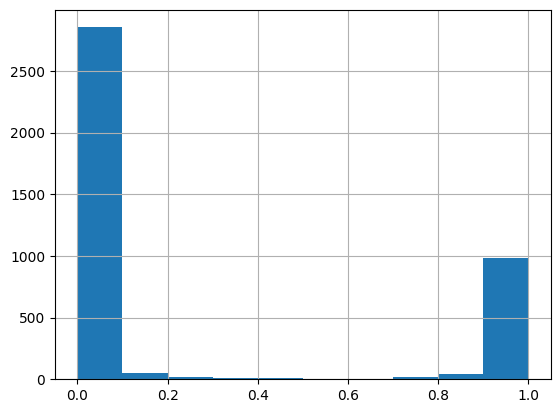

In [105]:
preds = predictor.predict_proba(data)
preds.iloc[:,1].hist()

### 테스트 데이터

In [51]:
preds = predictor.predict_proba(val_data)
labels = []
for proba in preds.iloc[:,1]:
  if proba >= 0.9:
    labels += [2]
  elif 0.5 <= proba <0.9:
    labels += [1]
  else:
    labels += [0]

In [55]:
pd.DataFrame(data = labels, columns=['lable']).value_counts().sort_index()

lable
0        595
1         41
2        164
Name: count, dtype: int64

### DB에 올릴 데이터 생성

In [ ]:
df = pd.read_csv("C:/Users/Playdata/Desktop/project2/gym_churn_us.csv")
df = df.rename(columns={"Churn": "target"})
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X['social_connected'] = X['Partner'] + X['Promo_friends'] + X['Group_visits']   # 고객의 사회적 연결이 얼마나 되어있는지 나타내는 피쳐
X['avg_monthly_add_charge'] = X['Avg_additional_charges_total'] / (X['Lifetime'] + 1)   # 평균 추가 요금의 시간 기준 비율
X['class_freq_ratio'] = X['Avg_class_frequency_current_month'] / (X['Avg_class_frequency_total'] + 1e-5)    # 클래스 이용 변화율 (최근 대비 전체)
X['class_freq_change'] = X['Avg_class_frequency_current_month'] - X['Avg_class_frequency_total']    # 이용 행동 변화량
X['contract_ending_soon'] = (X['Month_to_end_contract'] <= 1).astype(int)      # 계약 만료 임박 여부 (1개월 이내)
X['social_connected_ratio'] = (X['Partner'] + X['Promo_friends'] + X['Group_visits']) / 3     # 사회적 연결의 강도 비율

In [14]:
result_df = X.copy()
result_df['target'] = y
preds = predictor.predict(data)
result_df['predict'] = preds
preds_proba = predictor.predict_proba(data)
result_df['predict_proba'] = preds_proba.iloc[:,1]

labels = []
for proba in result_df['predict_proba']:
  if proba >= 0.9:
    labels += [2]
  elif 0.5 <= proba <0.9:
    labels += [1]
  else:
    labels += [0]

result_df['risk_label'] = labels

C:\Users\Playdata\miniconda3\envs\env1\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
C:\Users\Playdata\miniconda3\envs\env1\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code w

In [15]:
result_df

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,...,social_connected,avg_monthly_add_charge,class_freq_ratio,class_freq_change,contract_ending_soon,social_connected_ratio,target,predict,predict_proba,risk_label
0,1,1,1,1,0,6,1,29,14.227470,5.0,...,3,3.556868,0.000000,-0.020398,0,1.000000,0,0,0.039583,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,...,1,14.150367,0.993394,-0.012693,0,0.333333,0,0,0.003928,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,...,1,43.149493,0.934051,-0.122596,1,0.333333,0,0,0.278890,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,...,3,20.889954,1.047283,0.151582,0,1.000000,0,0,0.004336,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,...,2,49.590566,1.005551,0.006194,1,0.666667,0,0,0.067944,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,...,1,0.267336,1.028261,0.064572,0,0.333333,0,0,0.003992,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,...,1,34.441882,0.229301,-0.984309,1,0.333333,1,1,0.989941,2
3997,1,1,1,1,1,12,0,28,78.250542,11.0,...,2,26.083514,1.016253,0.045293,0,0.666667,0,0,0.004363,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,...,2,15.478164,0.979215,-0.033872,0,0.666667,0,0,0.007605,0


In [16]:
result_df.to_csv('project2_db_data.csv', index=False)